<div style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">
  <h1>sketch2clipart model</h1>
    Notebook to use the model! 
</div>

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Imports & Functions</h1>
</div>

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

In [2]:
# Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.down1 = self.conv_block(in_channels, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        
        self.up1 = self.up_conv_block(512, 256)
        self.up2 = self.up_conv_block(512, 128)
        self.up3 = self.up_conv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)
        self.tanh = nn.Tanh()
    
    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    
    def up_conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        u1 = self.up1(d4)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        out = self.final(u3)
        return self.tanh(out)

# Discriminator
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, sketch, clipart):
        x = torch.cat([sketch, clipart], dim=1)
        return self.model(x)

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Load Model Weights</h1>
</div>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Redefine the model architectures
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

# Load weights
generator.load_state_dict(torch.load("generator_sketch2clipart.pth"))
discriminator.load_state_dict(torch.load("discriminator_sketch2clipart.pth"))

generator.eval()
discriminator.eval()

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Try it out!</h1>
</div>

In [4]:
def display_sketch_and_generated(generator, sketch_number, device="cpu"):
    """
    Display the original sketch and the generated clipart side by side.
    
    Args:
        generator: Trained generator model.
        sketch_number: Number of the sketch file (e.g., 2 for 'sketch2.png').
        device: 'cpu' or 'cuda'
    """
    # Load sketch image
    sketch_path = f"data/sketch/sketch{sketch_number}.png"
    sketch = Image.open(sketch_path).convert("RGB")
    
    # Transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    sketch_tensor = transform(sketch).unsqueeze(0).to(device)

    # Generate clipart
    generator.eval()
    with torch.no_grad():
        generated_clipart = generator(sketch_tensor)
        generated_clipart = nn.functional.interpolate(
            generated_clipart, size=(256, 256), mode='bilinear', align_corners=False
        )
        generated_clipart = (generated_clipart.squeeze().cpu() + 1) / 2  # Denormalize to [0, 1]

    # Convert original sketch for plotting
    sketch_for_plot = (sketch_tensor.squeeze().cpu() + 1) / 2  # Denormalize
    sketch_for_plot = np.transpose(sketch_for_plot.numpy(), (1, 2, 0))

    # Convert generated clipart for plotting
    generated_for_plot = np.transpose(generated_clipart.numpy(), (1, 2, 0))

    # Plot side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(sketch_for_plot)
    plt.axis('off')
    plt.title(f"Sketch {sketch_number}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(generated_for_plot)
    plt.axis('off')
    plt.title(f"Generated Clipart {sketch_number}")
    
    plt.show()

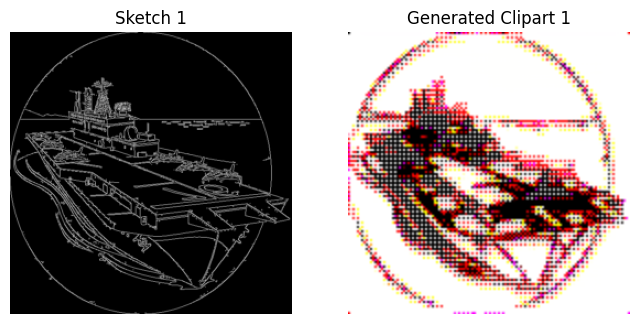

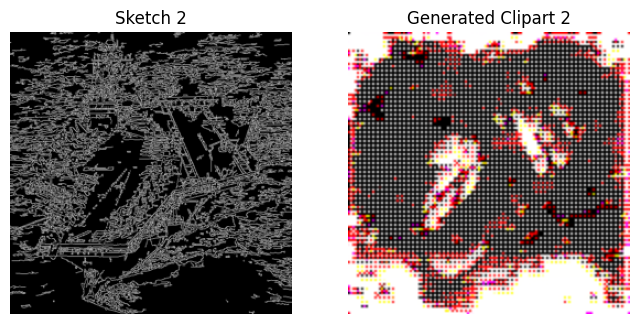

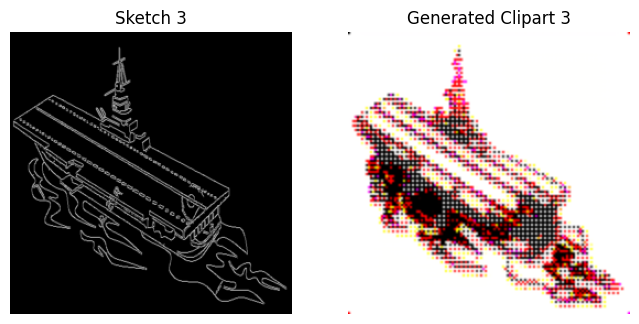

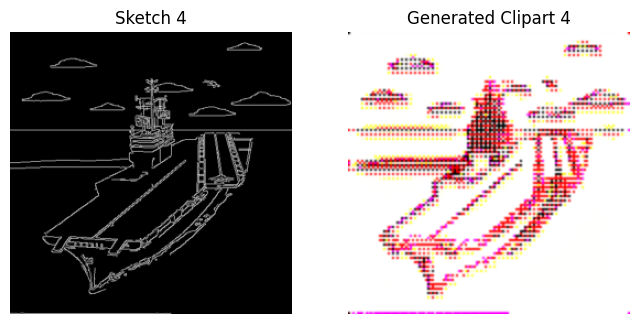

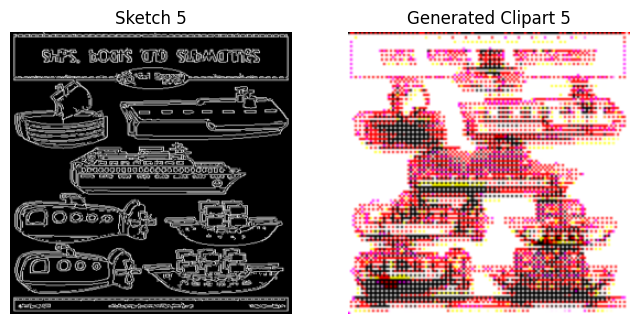

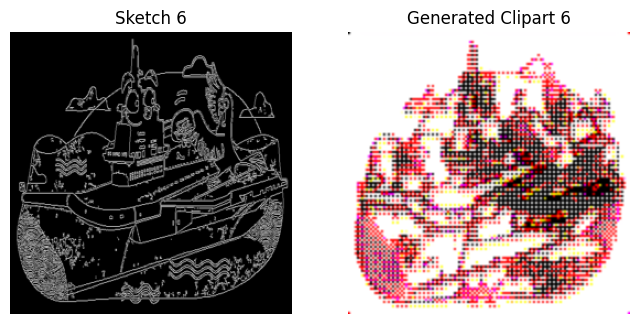

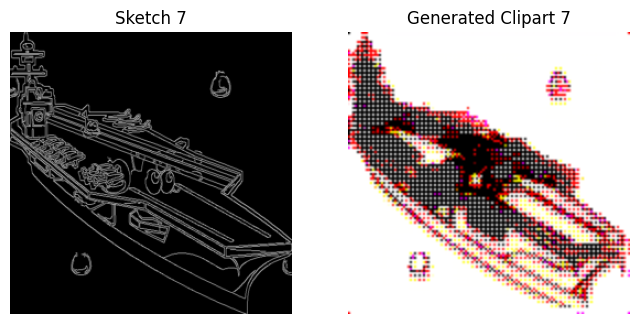

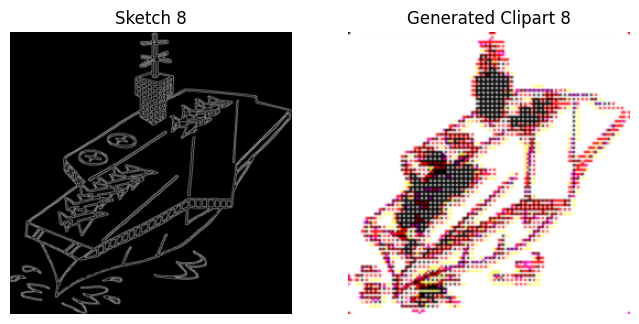

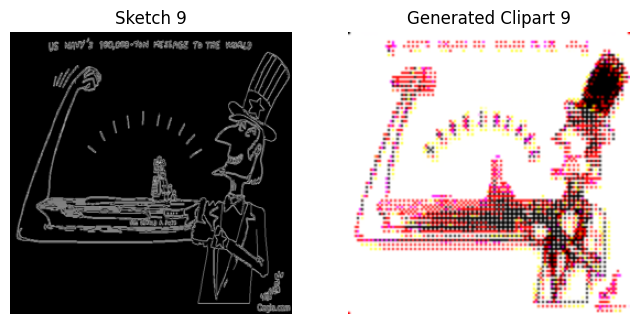

In [5]:
for i in range(1, 10): 
    display_sketch_and_generated(generator, i, device=device)